In [1]:
# Bruno Ugolini

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import nltk

# 1. Sentiment analysis

Using the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), we want to do a regression model that predict the ratings are on a 1-10 scale. You have an example train and test set in the `dataset` folder.

### 1.1 Regression Model

Use a feedforward neural network and NLP techniques we've seen up to now to train the best model you can on this dataset

### 1.2 RNN model

Train a RNN to do the sentiment analysis regression. The RNN should consist simply of an embedding layer (to make word IDs into word vectors) a recurrent blocks (GRU or LSTM) feeding into an output layer.

### Read in the data for review and ratings separated by train and test directories

In [3]:
def build_dataset(data_dir, sub):
    """
    Find the data and read it into a dataframe
    """
    files = os.listdir(path=data_dir+sub)
    rating = []
    txt = []
    for file in files:
        rating.append(file.split('_')[-1].split('.')[0])
        with open(data_dir+sub+'\\'+file, mode='r', encoding='UTF-8') as f:
            txt.append(f.read())
    return rating, txt

ratings = []
txt = []
train_dir = 'D:\\Shopee_Data\\aclImdb\\train\\'
for sub in ['pos', 'neg']:
    r, t = build_dataset(train_dir, sub)
    ratings.extend(r)
    txt.extend(t)

df_train = pd.DataFrame(data=np.transpose([ratings, txt]),columns=['rating','review'])
df_train.rating = df_train.rating.astype(float)

ratings = []
txt = []
test_dir = 'D:\\Shopee_Data\\aclImdb\\test\\'
for sub in ['pos', 'neg']:
    r, t = build_dataset(test_dir, sub)
    ratings.extend(r)
    txt.extend(t)
    
df_test = pd.DataFrame(data=np.transpose([ratings, txt]),columns=['rating','review'])
df_test.rating = df_test.rating.astype(float)

In [4]:
df_train

,rating,review
0,9.0,Bromwell High is a cartoon comedy. It ran at t...
1,8.0,Homelessness (or Houselessness as George Carli...
2,10.0,Brilliant over-acting by Lesley Ann Warren. Be...
3,7.0,This is easily the most underrated film inn th...
4,8.0,This is not the typical Mel Brooks film. It wa...
...,...,...
24995,4.0,"Towards the end of the movie, I felt it was to..."
24996,3.0,This is the kind of movie that my enemies cont...
24997,3.0,I saw 'Descent' last night at the Stockholm Fi...
24998,1.0,Some films that you pick up for a pound turn o...


# Question 1.2:

### Select a subset of the training dataset to train the RNN

In [5]:
N_TRAIN = 3_000
train_sents = df_train.sample(N_TRAIN,random_state=42)

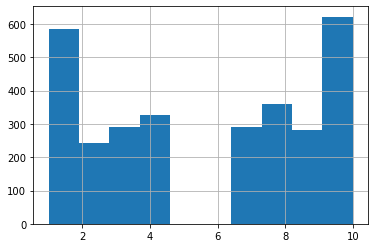

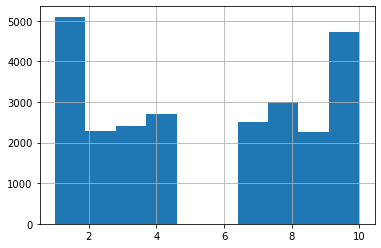

In [6]:
# compare distributions of ratings
# in sample vs. total
train_sents.rating.hist();
plt.show()
df_train.rating.hist();

## Tokenize the data

In [7]:
# training dataset
train_sents['tokens'] = train_sents['review'].apply(nltk.word_tokenize)

In [8]:
df_test['tokens'] = df_test['review'].apply(nltk.word_tokenize)

### Find the Parts of Speech (POS)

In [9]:
# to extract pos from the tuple of (word, POS)
def split_row(row):
    dets = []
    for tpl in row:
        t, d = tpl
        dets.append(d)
    return dets

In [10]:
train_sents['POS'] = train_sents['tokens'].apply(nltk.pos_tag)
train_sents['pos'] = train_sents['POS'].apply(split_row)

In [11]:
df_test['POS'] = df_test['tokens'].apply(nltk.pos_tag)
df_test['pos'] = df_test['POS'].apply(split_row)

In [12]:
train_sents = train_sents.drop('POS',1)

In [13]:
df_test = df_test.drop('POS',1)

### Following the lectures notes for the next cells

In [14]:
def make_lexicon(token_seqs, min_freq=1):
    '''Create a lexicon for the words in the sentences as well as the tags'''
    # First, count how often each word appears in the text.
    token_counts = {}
    for seq in token_seqs:
        for token in seq:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1

    # Then, assign each word to a numerical index. Filter words that occur less than min_freq times.
    lexicon = [token for token, count in token_counts.items() if count >= min_freq]
    # Indices start at 1. 0 is reserved for padding, and 1 is reserved for unknown words.
    lexicon = {token:idx + 2 for idx,token in enumerate(lexicon)}
    lexicon[u'<UNK>'] = 1 # Unknown words are those that occur fewer than min_freq times
    lexicon_size = len(lexicon)

    print("LEXICON SAMPLE ({} total items):".format(len(lexicon)))
    print(dict(list(lexicon.items())[:20]))
    
    return lexicon

print("WORDS:")
words_lexicon = make_lexicon(train_sents['tokens'])
print("TAGS:")
tags_lexicon = make_lexicon(train_sents['pos'])

WORDS:
LEXICON SAMPLE (42386 total items):
{'In': 2, 'Panic': 3, 'The': 4, 'Streets': 5, 'Richard': 6, 'Widmark': 7, 'plays': 8, 'U.S.': 9, 'Navy': 10, 'doctor': 11, 'who': 12, 'has': 13, 'his': 14, 'week': 15, 'rudely': 16, 'interrupted': 17, 'with': 18, 'a': 19, 'corpse': 20, 'that': 21}
TAGS:
LEXICON SAMPLE (46 total items):
{'IN': 2, 'NNP': 3, 'DT': 4, 'VBZ': 5, 'NN': 6, 'WP': 7, 'PRP$': 8, 'RB': 9, 'VBN': 10, 'WDT': 11, '.': 12, 'RP': 13, 'VBD': 14, 'CD': 15, 'NNS': 16, ',': 17, 'PRP': 18, 'VBP': 19, 'JJ': 20, 'TO': 21}


In [15]:
def get_lexicon_lookup(lexicon):
    '''Make a dictionary where the string representation 
        of a lexicon item can be retrieved 
        from its numerical index
    '''
    lexicon_lookup = {idx: lexicon_item for lexicon_item, idx in lexicon.items()}
    print("LEXICON LOOKUP SAMPLE:")
    print(dict(list(lexicon_lookup.items())[:20]))
    return lexicon_lookup

def tokens_to_idxs(token_seqs, lexicon):
    idx_seqs = [[lexicon[token] if token in lexicon else lexicon['<UNK>'] for token in token_seq]  
                                                                     for token_seq in token_seqs]
    return idx_seqs

train_sents['Sentence_Idxs'] = tokens_to_idxs(train_sents['tokens'], words_lexicon)
train_sents['Tag_Idxs'] = tokens_to_idxs(train_sents['pos'], tags_lexicon)

# tags_lexicon_lookup = get_lexicon_lookup(tags_lexicon)

In [16]:
from keras_preprocessing.sequence import pad_sequences

In [17]:
# max_seq_len = max([len(idx_seq) for idx_seq in train_sents['Sentence_Idxs']]) # Get length of longest sequence
max_seq_len = 500

In [18]:
def pad_idx_seqs(idx_seqs, max_seq_len):
    # Keras provides a convenient padding function; 
    padded_idxs = pad_sequences(sequences=idx_seqs, maxlen=max_seq_len)
    return padded_idxs

train_padded_words = pad_idx_seqs(train_sents['Sentence_Idxs'], 
                                  max_seq_len + 1) #Add one to max length for offsetting sequence by 1
train_padded_tags = pad_idx_seqs(train_sents['Tag_Idxs'],
                                 max_seq_len + 1)  #Add one to max length for offsetting sequence by 1

print("WORDS:\n", train_padded_words)
print("SHAPE:", train_padded_words.shape, "\n")

print("TAGS:\n", train_padded_tags)
print("SHAPE:", train_padded_tags.shape, "\n")

WORDS:
 [[   35    36    37 ...    80   258    24]
 [    0     0     0 ...   314   280    24]
 [    0     0     0 ...   213   361    24]
 ...
 [    0     0     0 ...    32   290    24]
 [    0     0     0 ... 28277   626    24]
 [    0     0     0 ... 16914  3029    24]]
SHAPE: (3000, 501) 

TAGS:
 [[ 2 15 16 ... 20 16 12]
 [ 0  0  0 ... 20  6 12]
 [ 0  0  0 ...  9 20 12]
 ...
 [ 0  0  0 ...  4  6 12]
 [ 0  0  0 ...  6 38 12]
 [ 0  0  0 ... 20  6 12]]
SHAPE: (3000, 501) 



In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, TimeDistributed, Dense
from tensorflow.keras.layers import Embedding, GRU, LSTM

In [21]:
def create_model(seq_input_len, n_word_input_nodes, n_tag_input_nodes, n_word_embedding_nodes,
                 n_tag_embedding_nodes, n_hidden_nodes, stateful=False, batch_size=None):
    
    #Layers 1
    word_input = Input(batch_shape=(batch_size, seq_input_len), name='word_input_layer')
    tag_input = Input(batch_shape=(batch_size, seq_input_len), name='tag_input_layer')

    #Layers 2
    word_embeddings = Embedding(input_dim=n_word_input_nodes,
                                output_dim=n_word_embedding_nodes, 
                                mask_zero=True, name='word_embedding_layer')(word_input) #mask_zero will ignore 0 padding
    #Output shape = (batch_size, seq_input_len, n_word_embedding_nodes)
    tag_embeddings = Embedding(input_dim=n_tag_input_nodes,
                               output_dim=n_tag_embedding_nodes,
                               mask_zero=True, name='tag_embedding_layer')(tag_input) 
    #Output shape = (batch_size, seq_input_len, n_tag_embedding_nodes)
    
    #Layer 3
    merged_embeddings = Concatenate(axis=-1, name='concat_embedding_layer')([word_embeddings, tag_embeddings])
    #Output shape =  (batch_size, seq_input_len, n_word_embedding_nodes + n_tag_embedding_nodes)
    
    #Layer 4
    hidden_layer = LSTM(units=n_hidden_nodes, return_sequences=False, 
                       stateful=stateful, name='hidden_layer')(merged_embeddings)
#     hidden_layer = GRU(units=n_hidden_nodes, return_sequences=False, 
#                        stateful=stateful, name='hidden_layer')(merged_embeddings)
#     hidden_layer = GRU(units=n_hidden_nodes, return_sequences=True, 
#                        stateful=stateful, name='hidden_layer')(merged_embeddings)
    #Output shape = (batch_size, seq_input_len, n_hidden_nodes)
    
    #Layer 5
    output_layer = Dense(10,activation='softmax', name='output_layer')(hidden_layer)
#     output_layer = TimeDistributed(Dense(units=n_tag_input_nodes, 
#                                          activation='softmax'), name='output_layer')(hidden_layer)
    # Output shape = (batch_size, seq_input_len, n_tag_input_nodes)
    
    #Specify which layers are input and output, compile model with loss and optimization functions
    model = Model(inputs=[word_input, tag_input], outputs=output_layer)
    model.compile(loss="categorical_crossentropy",
                  optimizer='adam')
    
    return model

In [22]:
len(words_lexicon) + 1, len(tags_lexicon) + 1

(42387, 47)

In [23]:
model = create_model(seq_input_len=train_padded_words.shape[-1] - 1, #substract 1 from matrix length because of offset
                     n_word_input_nodes=len(words_lexicon) + 1, #Add one for 0 padding
                     n_tag_input_nodes=len(tags_lexicon) + 1, #Add one for 0 padding
                     n_word_embedding_nodes=300,
                     n_tag_embedding_nodes=100,
                     n_hidden_nodes=500)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input_layer (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
tag_input_layer (InputLayer)    [(None, 500)]        0                                            
__________________________________________________________________________________________________
word_embedding_layer (Embedding (None, 500, 300)     12716100    word_input_layer[0][0]           
__________________________________________________________________________________________________
tag_embedding_layer (Embedding) (None, 500, 100)     4700        tag_input_layer[0][0]            
_______________________________________________________________________________________

In [24]:
from tensorflow.keras.utils import to_categorical

In [25]:
y_cat = to_categorical(train_sents['rating']-1, num_classes=10)

In [26]:
model.fit(x=[train_padded_words[:,1:], train_padded_tags[:,:-1]], 
#           y=train_sents['rating'][:,].to_numpy(), 
          y=y_cat, 
          batch_size=32, epochs=8)

Epoch 1/8
94/94 [==============================] - 137s 1s/step - loss: 2.0721
Epoch 2/8
94/94 [==============================] - 138s 1s/step - loss: 1.9234
Epoch 3/8
94/94 [==============================] - 139s 1s/step - loss: 1.3117
Epoch 4/8
94/94 [==============================] - 137s 1s/step - loss: 0.6624
Epoch 5/8
94/94 [==============================] - 138s 1s/step - loss: 0.2905
Epoch 6/8
94/94 [==============================] - 136s 1s/step - loss: 0.1606
Epoch 7/8
94/94 [==============================] - 137s 1s/step - loss: 0.0603
Epoch 8/8
94/94 [==============================] - 136s 1s/step - loss: 0.0632


In [27]:
test_sents = df_test.copy()

In [28]:
test_sents['Sentence_Idxs'] = tokens_to_idxs(test_sents['tokens'], words_lexicon)
test_sents['Tag_Idxs'] = tokens_to_idxs(test_sents['pos'], tags_lexicon)

test_padded_words = pad_idx_seqs(test_sents['Sentence_Idxs'], 
                                  max_seq_len + 1) #Add one to max length for offsetting sequence by 1
test_padded_tags = pad_idx_seqs(test_sents['Tag_Idxs'],
                                 max_seq_len + 1)  #Add one to max length for offsetting sequence by 1

In [29]:
y_pred_vec = model.predict([test_padded_words[:,1:], test_padded_tags[:,:-1]], 
                           batch_size=32)

In [30]:
y_pred = np.argmax(y_pred_vec,axis=1)+1

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
accuracy_score(df_test['rating'], y_pred)

0.29744

# Question 1.1:

### Select a subset of the training dataset to train the FFNN

In [33]:
N_TRAIN = 3_000
train_sents = df_train.sample(N_TRAIN,random_state=42)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer

In [38]:
nltk.download('wordnet');
nltk.download('stopwords');

[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Users\Pinhead\anaconda3\envs\tf-
[nltk_data]     gpu\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\Pinhead\anaconda3\envs\tf-
[nltk_data]     gpu\lib\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### Custom stop words

In [39]:
from nltk.corpus import stopwords

In [40]:
print(stopwords.words('English'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [41]:
to_remove_from_stop = ['above', 'below', 'up', 'down', 'over', 'under', 'again', 
                       'more', 'most', 'no', 'not', 'only', 'too', 'very', "do", 
                       "don't", 'should', 'shouldn', "shouldn't", 'wasn', "wasn't", 
                       'weren', "weren't",'won', "won't", 'wouldn', "wouldn't"]

In [42]:
my_stop_words = stopwords.words('English')
for w in to_remove_from_stop:
    my_stop_words.remove(w)
print(my_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'to', 'from', 'in', 'out', 'on', 'off', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'other', 'some', 'such', 'nor', 'own', 'same', 'so', 'than', 's', 't', 'can', 'will', 'just', 'don', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain

### Get rid of html and perform other cleaning of words

In [43]:
# this code appears in many sites on internet and I took it and modified it for the stop words
lemmatizer = WordNetLemmatizer()

# function that receive a list of words and do lemmatization:
def lemma_stem_text(words_list):
    # Lemmatizer
    # eighties->eight or messages->message or drugs->drug
    text = [lemmatizer.lemmatize(token.lower()) for token in words_list]
    # going-> go or started->start or watching->watch
    text = [lemmatizer.lemmatize(token.lower(), "v") for token in text]
    return text

re_negation = re.compile("n't ")

# function that receive a sequence of woords and return the same sequence transforming
# abbreviated negations to the standard form.
def negation_abbreviated_to_standard(sent):
    sent = re_negation.sub(" not ", sent)
    return sent

def review_to_words(raw_review):
    # 1. Remove HTML tags
#    review_text = BeautifulSoup(raw_review).get_text() 

    # 2. Transform abbreviated negations to the standard form.
    review_text = negation_abbreviated_to_standard(raw_review)

    # 3. Remove non-letters and non-numbers   
    letters_numbers_only = re.sub("[^a-zA-Z_0-9]", " ", review_text) 
    
    # 4. Convert to lower case and split into individual words (tokenization)
    words = np.char.lower(letters_numbers_only.split())                             

    # 5. Remove stop words
    # stop words not used in final version
#    meaningful_words = [w for w in words if not w in my_stop_words]   
    meaningful_words = [w for w in words]   

    # 6. Apply lemmatization function
    lemma_words = lemma_stem_text(meaningful_words)
    
    # 7. Join the words back into one string separated by space, and return the result.
    return( " ".join(lemma_words))   

In [44]:
train_sents

,rating,review
6868,8.0,In Panic In The Streets Richard Widmark plays ...
24016,1.0,If you ask me the first one was really better ...
9668,10.0,I am a big fan a Faerie Tale Theatre and I've ...
13640,1.0,I just finished reading a book about Dillinger...
14018,2.0,Greg Davis and Bryan Daly take some crazed sta...
...,...,...
24897,3.0,This was not a well done western. You've got t...
1084,8.0,I took this out arbitrarily from the library t...
10352,9.0,To watch this film from start to finish withou...
24197,1.0,As with many other pop-culture franchise serie...


In [45]:
words = train_sents.review.apply(review_to_words).str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571
0,in,panic,in,the,street,richard,widmark,play,u,s,...,None,None,None,None,None,None,None,None,None,None
1,if,you,ask,me,the,first,one,wa,really,better,...,None,None,None,None,None,None,None,None,None,None
2,i,be,a,big,fan,a,faerie,tale,theatre,and,...,None,None,None,None,None,None,None,None,None,None
3,i,just,finish,read,a,book,about,dillinger,this,movie,...,None,None,None,None,None,None,None,None,None,None
4,greg,davis,and,bryan,daly,take,some,craze,statement,by,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,this,wa,not,a,well,do,western,you,ve,get,...,None,None,None,None,None,None,None,None,None,None
2996,i,take,this,out,arbitrarily,from,the,library,the,other,...,None,None,None,None,None,None,None,None,None,None
2997,to,watch,this,film,from,start,to,finish,without,burst,...,None,None,None,None,None,None,None,None,None,None
2998,a,with,many,other,pop,culture,franchise,series,this,line,...,None,None,None,None,None,None,None,None,None,None


D:\Users\Pinhead\anaconda3\envs\tf-gpu\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Users\Pinhead\anaconda3\envs\tf-gpu\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


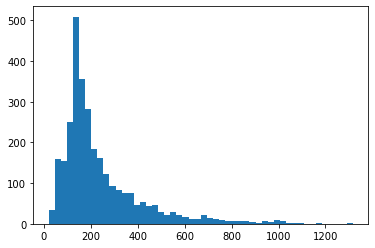

In [46]:
# see how long (word count) are the reviews
is_missing = words.isna().values
# first Nan is the location where the first None appears 
# hence, the end of the review.
first_nan = np.where(is_missing.any(1), is_missing.argmax(1), np.nan)
plt.hist(first_nan,bins=50);

### Create a new dataframe like "words" but with an additional column that represents the number of non-Nan columns in each row. Call this column frst_nan.

In [47]:
words_fl = pd.concat([words,
                      pd.Series(first_nan,
                                name='frst_nan',
                                dtype=int)
                      .fillna(value=words.shape[1]-1)
                      .astype(int)], axis=1)
words_fl

,0,1,2,3,4,5,6,7,8,9,...,1563,1564,1565,1566,1567,1568,1569,1570,1571,frst_nan
0,in,panic,in,the,street,richard,widmark,play,u,s,...,None,None,None,None,None,None,None,None,None,474
1,if,you,ask,me,the,first,one,wa,really,better,...,None,None,None,None,None,None,None,None,None,139
2,i,be,a,big,fan,a,faerie,tale,theatre,and,...,None,None,None,None,None,None,None,None,None,152
3,i,just,finish,read,a,book,about,dillinger,this,movie,...,None,None,None,None,None,None,None,None,None,169
4,greg,davis,and,bryan,daly,take,some,craze,statement,by,...,None,None,None,None,None,None,None,None,None,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,this,wa,not,a,well,do,western,you,ve,get,...,None,None,None,None,None,None,None,None,None,99
2996,i,take,this,out,arbitrarily,from,the,library,the,other,...,None,None,None,None,None,None,None,None,None,185
2997,to,watch,this,film,from,start,to,finish,without,burst,...,None,None,None,None,None,None,None,None,None,306
2998,a,with,many,other,pop,culture,franchise,series,this,line,...,None,None,None,None,None,None,None,None,None,140


## Define some functions for feature engineering

In [48]:
def shift_row(row, sntc_ln=100):
    """
    From each row (review) take 
    the first and last sentence (word
    count) as defined by sntc_ln.
    """
    # get the first occurence of None
    # for this row.
    frst_nan = row['frst_nan']
    # if review is less than two 
    # sentences long, take the
    # columns up to 2 * sentence length
    if frst_nan <= 2*sntc_ln:
        return row.iloc[:int(2*sntc_ln)].values
    # else ...
    else:
        # grab first sentence length
        sen1 = row.iloc[:sntc_ln]
        # grab the last sentence length
        sen2 = row.iloc[frst_nan-sntc_ln-1:frst_nan-1]
        return np.concatenate((sen1,sen2))

def soft_get(w):
    """
    Convert a single word to a 
    word vector as provided by
    the loaded gensim model.
    """
    try:
        # retrieve the word vector if it exists
        return word_vectors[w]
    except KeyError:
        # fill the vector space with zeros otherwise
        # - justified because we are summing the 
        #   word vectors in map_vectors
        return np.zeros(word_vectors.vector_size)

def map_vectors(row, take_mean=True):
    """
    Convert a row of words (with some NaN's)
    to the sum of these word vectors
    according to the gensim model.
    """
    if np.sum(row.notna()) == 0:
        # if entirely zeros, return zeros
        # - but this should be eliminated 
        #   at some point to avoid singular matrix
        return np.zeros(word_vectors.vector_size)
    if take_mean:
        try:
            # otherwise, return the mean of the 
            # word vectors
            return np.mean(
                row.loc[row.notna()].apply(soft_get)
            )
        except:
            # if error return zeros
            return np.zeros(word_vectors.vector_size)
    else:
        try:
            # otherwise, return the sum of the 
            # word vectors
            return np.sum(
                row.loc[row.notna()].apply(soft_get)
            )
        except:
            # if error return zeros
            return np.zeros(word_vectors.vector_size)

## Define a class for feature engineering

In [49]:
class SelectSentences(BaseEstimator, TransformerMixin):
    """
    Create a class of inheritance from 
    BaseEstimator and TransformerMixin in
    order to get the .fit and .transform
    methods.
    This will allow us to perform feature
    engineering with these methods and
    then use the class in a pipeline
    """
    def __init__(self, use_gensim=True, 
                 take_mean=True, 
                 stnd_rows=False, 
                 sntc_len=100): # no *args or **kargs
        self.sntc_len = sntc_len # length of sentence to use for 1st and last
        self.take_mean = take_mean # whether to take mean of sum of vectors for gensim
        self.stnd_rows = stnd_rows # whether to standardize rows or not for gensim
        self.use_gensim = use_gensim # whether of not to use gensim
        
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        # Do all the feature engineering
        # we want to do here.
        # In our case, the function was
        # already defined. Just call it.
        
        # create the series where only
        # the required # of words in each
        # row are retained.
        X_sntc = X.apply(shift_row, 
                         args=(self.sntc_len,), 
                         axis=1)
        if self.use_gensim:
            X_sntc = pd.DataFrame(X_sntc.to_list())
        else:
            X_sntc = pd.DataFrame(X_sntc)
            X_sntc = X_sntc[0].agg(lambda x: ','.join(map(str, x)).replace(',',' ')).to_list()
        
        if self.use_gensim:
            # Apply the word vector transformation
            # using either the sum or mean of 
            # the word vectors.
            X_sntc = pd.DataFrame(X_sntc.apply(map_vectors, 
                                               args=(self.take_mean,),
                                               axis=1)
                                  .tolist())
            # Finally, take the MinMaxScaler of 
            # each row if called for.
            X_sntc = X_sntc.to_numpy()
            if self.stnd_rows:
                scalar = MinMaxScaler()
                scalar.fit(np.transpose(X_sntc))
                X_sntc = scalar.transform(np.transpose(X_sntc))
                X_sntc = np.transpose(X_sntc)
        return X_sntc

### Create the X and y and split into X_train and X_test variables.

In [56]:
X = words_fl.copy()
y_cat = to_categorical(train_sents['rating']-1, num_classes=10)

In [57]:
# treat the data step-by-step with the functions
# defined above
SelSent = SelectSentences(sntc_len=500, 
                          stnd_rows=False, 
                          take_mean=False, 
                          use_gensim=False)
SelSent.fit(X)
X = SelSent.transform(X)

In [58]:
TFidf = TfidfVectorizer(max_df=0.95, 
                        max_features=500, 
                        min_df=1, 
                        ngram_range=(1, 2), 
                        smooth_idf=False,
                        stop_words=None, 
                        sublinear_tf=True)
TFidf.fit(X)
X = TFidf.transform(X)

In [59]:
X.shape

(3000, 500)

In [63]:
from tensorflow.keras.models import Sequential

In [105]:
model = Sequential([
  Input(shape=(500,)),
  Dense(units=500, activation='relu'),
  Dense(units=256, activation='relu'),
  Dense(units=192, activation='relu'),
  Dense(units=128, activation='relu'),
  Dense(units=10, activation='softmax'),
])

In [106]:
model.compile(loss="categorical_crossentropy",
                  optimizer='adam')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_23 (Dense)             (None, 192)               49344     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               24704     
_________________________________________________________________
dense_25 (Dense)             (None, 10)                1290      
Total params: 454,094
Trainable params: 454,094
Non-trainable params: 0
_________________________________________________________________


In [75]:
from tensorflow.keras.utils import to_categorical

In [25]:
y_cat = to_categorical(train_sents['rating']-1, num_classes=10)

In [107]:
model.fit(x=X.todense(), 
          y=y_cat, 
          epochs=12)

Epoch 1/12
94/94 [==============================] - 0s 2ms/step - loss: 1.9128
Epoch 2/12
94/94 [==============================] - 0s 2ms/step - loss: 1.5471
Epoch 3/12
94/94 [==============================] - 0s 2ms/step - loss: 1.3678
Epoch 4/12
94/94 [==============================] - 0s 2ms/step - loss: 1.1631
Epoch 5/12
94/94 [==============================] - 0s 2ms/step - loss: 0.8132
Epoch 6/12
94/94 [==============================] - 0s 2ms/step - loss: 0.4988
Epoch 7/12
94/94 [==============================] - 0s 2ms/step - loss: 0.3019
Epoch 8/12
94/94 [==============================] - 0s 2ms/step - loss: 0.1661
Epoch 9/12
94/94 [==============================] - 0s 2ms/step - loss: 0.0782
Epoch 10/12
94/94 [==============================] - 0s 2ms/step - loss: 0.0487
Epoch 11/12
94/94 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 12/12
94/94 [==============================] - 0s 2ms/step - loss: 0.0165


In [86]:
test_words = df_test.review.apply(review_to_words).str.split()
test_words = pd.DataFrame(test_words.tolist())
is_missing = test_words.isna().values
first_nan = np.where(is_missing.any(1), is_missing.argmax(1), np.nan)
X_tt = pd.concat([test_words,
                      pd.Series(first_nan,
                                name='frst_nan',
                                dtype=int)
                      .fillna(value=test_words.shape[1]-1)
                      .astype(int)], axis=1)

In [88]:
# treat the data step-by-step with the functions
# defined above
SelSent = SelectSentences(sntc_len=500, 
                          stnd_rows=False, 
                          take_mean=False, 
                          use_gensim=False)
SelSent.fit(X_tt)
X_tt = SelSent.transform(X_tt)

In [89]:
TFidf = TfidfVectorizer(max_df=0.95, 
                        max_features=500, 
                        min_df=1, 
                        ngram_range=(1, 2), 
                        smooth_idf=False,
                        stop_words=None, 
                        sublinear_tf=True)
TFidf.fit(X_tt)
X_tt = TFidf.transform(X_tt)

In [90]:
X_tt.shape

(25000, 500)

In [108]:
y_pred_vec = model.predict(X_tt.todense(), 
                           batch_size=32)

In [109]:
y_pred = np.argmax(y_pred_vec,axis=1)+1

In [110]:
accuracy_score(df_test['rating'], y_pred)

0.17892

# 2. (evil) XOR Problem

Train an LSTM to solve the XOR problem: that is, given a sequence of bits, determine its parity. The LSTM should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

### 2.1 

Generate a dataset of random <=100,000 binary strings of equal length <= 50. Train the LSTM; what is the maximum length you can train up to with precisison?
    

### 2.2

Generate a dataset of random <=200,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?


In [1]:
import numpy as np
import random
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM


### Question 2.1

In [2]:
SEQ_LEN = 50
N_SMPL = 100_000

In [3]:
# create a binary sequence of desired length
data = np.array([[random.choice([0,1]) for _ in range(SEQ_LEN)] for _ in range(N_SMPL)])

In [4]:
not_data = np.array([[int(not(x)) for x in row] for row in data])
data = data[:,:,np.newaxis]
not_data = not_data[:,:,np.newaxis]
data.shape, not_data.shape

((100000, 50, 1), (100000, 50, 1))

In [5]:
data = np.concatenate((data,not_data),axis=2)
data.shape

(100000, 50, 2)

In [6]:
data[0,:,0], data[0,:,1] # the random data and its negation

(array([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1]),
 array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0]))

In [ ]:
# create the running XOR value by taking the modulo
# of 2 of the cummulative sum of the array
xor_run1 = np.array([[x % 2 for x in np.cumsum(row)] for row in data[:,:,0]])

### The key point to this method appears to be that one feeds the sequence (say, X) and its inverse (X_inv) into the model. At the same time, the sequence is accompanied by its true response (Y) whereas the inverse is accompanied by simply the inverse of the true response (Y_inv) instead of the true response of X_inv. The logic is that the lstm will learn to attribute correctly to a given sequence as distinguished from the inverse of the sequence.

In [7]:
xor_run2 = np.array([[int(not(x)) for x in row] for row in xor_run1])
xor_run1 = xor_run1[:,:,np.newaxis]
xor_run2 = xor_run2[:,:,np.newaxis]
xor_run = np.concatenate((xor_run1, xor_run2),axis=2)

In [8]:
xor_run.shape

(100000, 50, 2)

In [9]:
# this is the running XOR of the sequence above (in data)
xor_run[0,:,0], xor_run[0,:,1]

(array([1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0]),
 array([0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1]))

In [10]:
# create the model
model = Sequential()
model.add(Input(shape=(SEQ_LEN,2),dtype="float32"))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 1)             16        
_________________________________________________________________
dense (Dense)                (None, 50, 2)             4         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


### Length 50

In [12]:
model.fit(x=data.astype(np.float32), y=xor_run.astype(np.float32), epochs=10, batch_size=128)

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6929 - accuracy: 0.5094
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6651 - accuracy: 0.5614
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1180 - accuracy: 0.9936
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0403 - accuracy: 0.9985
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0220 - accuracy: 0.9993
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0138 - accuracy: 0.9996
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0093 - accuracy: 0.9998
Epoch 8/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0064 - accuracy: 0.9999
Epoch 9/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0046 - accuracy: 0.9999
Epoch 10/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0034 - accuracy: 0.9999

### Length 35

In [13]:
# create the model
SEQ_LEN = 35
model = Sequential()
model.add(Input(shape=(SEQ_LEN,2),dtype="float32"))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=data[:,:SEQ_LEN,:].astype(np.float32), 
          y=xor_run[:,:SEQ_LEN,:].astype(np.float32), epochs=10, batch_size=128)

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6930 - accuracy: 0.5068
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6418 - accuracy: 0.6110
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1779 - accuracy: 0.9989
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0801 - accuracy: 1.0000
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0479 - accuracy: 1.0000
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0312 - accuracy: 1.0000
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0212 - accuracy: 1.0000
Epoch 8/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0148 - accuracy: 1.0000
Epoch 9/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0105 - accuracy: 1.0000
Epoch 10/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0075 - accuracy: 1.0000

### Length 25

In [14]:
# create the model
SEQ_LEN = 25
model = Sequential()
model.add(Input(shape=(SEQ_LEN,2),dtype="float32"))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=data[:,:SEQ_LEN,:].astype(np.float32), 
          y=xor_run[:,:SEQ_LEN,:].astype(np.float32), epochs=10, batch_size=128)

Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6941 - accuracy: 0.4824
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6930 - accuracy: 0.5106
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6924 - accuracy: 0.5155
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6640 - accuracy: 0.5785
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.1711 - accuracy: 0.9970
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0678 - accuracy: 1.0000
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0404 - accuracy: 1.0000
Epoch 8/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0264 - accuracy: 1.0000
Epoch 9/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 10/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0126 - accuracy: 1.0000

### Length 15

In [15]:
# create the model
SEQ_LEN = 15
model = Sequential()
model.add(Input(shape=(SEQ_LEN,2),dtype="float32"))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=data[:,:SEQ_LEN,:].astype(np.float32), 
          y=xor_run[:,:SEQ_LEN,:].astype(np.float32), epochs=10, batch_size=128)

Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6879 - accuracy: 0.5288
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.5841 - accuracy: 0.6923
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.1993 - accuracy: 0.9931
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0884 - accuracy: 1.0000
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0516 - accuracy: 1.0000
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0329 - accuracy: 1.0000
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0220 - accuracy: 1.0000
Epoch 8/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0152 - accuracy: 1.0000
Epoch 9/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 10/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0076 - accuracy: 1.0000

### The model fits tremendously well all the way to a size of 50. "Fits" is defined as the XOR value of the full sequence.

## Question 2.2

In [31]:
SEQ_LEN = 100_000
# create the model
model = Sequential()
model.add(Input(shape=(None,2),dtype="float32"))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 1)           16        
_________________________________________________________________
dense_6 (Dense)              (None, None, 2)           4         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [32]:
def train_generator():
    while True:
        sequence_len = np.random.randint(1, 50)
        data = np.array([random.choice([0,1]) for _ in range(sequence_len)])
        not_data = np.array([int(not(x)) for x in data])
        data = data[:,np.newaxis]
        not_data = not_data[:,np.newaxis]
        x_train = np.concatenate((data,not_data),axis=1)
        xor_run1 = np.array([x % 2 for x in np.cumsum(x_train[:,0])])
        xor_run2 = np.array([int(not(x)) for x in xor_run1])
        xor_run1 = xor_run1[:,np.newaxis]
        xor_run2 = xor_run2[:,np.newaxis]
        y_train = np.concatenate((xor_run1, xor_run2),axis=1)
        x_train = x_train[np.newaxis, :, :]
        y_train = y_train[np.newaxis, :, :]
        #print(x_train.shape, y_train.shape)
        yield x_train.astype(np.float32), y_train.astype(np.float32)

model.fit_generator(train_generator(), steps_per_epoch=782, epochs=10)

Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6960 - accuracy: 0.4881
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6928 - accuracy: 0.5159
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6900 - accuracy: 0.5155
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6865 - accuracy: 0.5141
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6760 - accuracy: 0.5330
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6416 - accuracy: 0.5814
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2277 - accuracy: 0.9594
Epoch 8/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0850 - accuracy: 0.9937
Epoch 9/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0428 - accuracy: 0.9988
Epoch 10/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0309 - accuracy: 0.9977

### Let's bump it up to 200_000

In [33]:
SEQ_LEN = 200_000
# create the model
model = Sequential()
model.add(Input(shape=(None,2),dtype="float32"))
model.add(LSTM(1, return_sequences=True))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 1)           16        
_________________________________________________________________
dense_7 (Dense)              (None, None, 2)           4         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [34]:
def train_generator():
    while True:
        sequence_len = np.random.randint(1, 50)
        data = np.array([random.choice([0,1]) for _ in range(sequence_len)])
        not_data = np.array([int(not(x)) for x in data])
        data = data[:,np.newaxis]
        not_data = not_data[:,np.newaxis]
        x_train = np.concatenate((data,not_data),axis=1)
        xor_run1 = np.array([x % 2 for x in np.cumsum(x_train[:,0])])
        xor_run2 = np.array([int(not(x)) for x in xor_run1])
        xor_run1 = xor_run1[:,np.newaxis]
        xor_run2 = xor_run2[:,np.newaxis]
        y_train = np.concatenate((xor_run1, xor_run2),axis=1)
        x_train = x_train[np.newaxis, :, :]
        y_train = y_train[np.newaxis, :, :]
        #print(x_train.shape, y_train.shape)
        yield x_train.astype(np.float32), y_train.astype(np.float32)

model.fit_generator(train_generator(), steps_per_epoch=782, epochs=10)

Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6930 - accuracy: 0.5003
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6923 - accuracy: 0.5106
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6904 - accuracy: 0.5191
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6895 - accuracy: 0.5134
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6820 - accuracy: 0.5250
Epoch 6/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6618 - accuracy: 0.5534
Epoch 7/10
782/782 [==============================] - 3s 4ms/step - loss: 0.5800 - accuracy: 0.6735
Epoch 8/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2705 - accuracy: 0.9660
Epoch 9/10
782/782 [==============================] - 3s 4ms/step - loss: 0.1188 - accuracy: 0.9928
Epoch 10/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0603 - accuracy: 0.9982

## There appears to be no loss of accuracy with this method even with variable vector lengths.
